In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [52]:
rym = pd.read_csv("./rym-songs.csv")
data = rym.to_numpy()
X = data[:, :-3].astype(np.float64)
y = data[:, -1].astype(np.float64)
X_train, X_other, y_train, y_other = train_test_split(X,y,test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, test_size=0.4)

In [53]:
from sklearn.linear_model import Ridge, RidgeClassifier, Lasso

In [54]:
l2model = Ridge()
l2model.fit(X_train, y_train)
y_pred = l2model.predict(X_val)
np.sqrt(np.mean((y_pred - y_val) ** 2))

0.5229867112955853

In [55]:
l1model = Lasso()
l1model.fit(X_train, y_train)
y_pred = l1model.predict(X_val)
np.sqrt(np.mean((y_pred - y_val) ** 2))

0.5256186589425761

In [56]:
import torch
from torch import nn
import matplotlib.pyplot as plt
device = 'cpu'

In [57]:
def display_error_curves(training_losses, validation_losses):
    """
    Plots the training and validation loss curves
    training_losses and validation_losses should be lists or arrays of the same length
    """
    num_epochs = len(training_losses)

    plt.plot(range(num_epochs), training_losses, label="Training Loss")
    plt.plot(range(num_epochs), validation_losses, label="Validation Loss")

    # Add in a title and axes labels
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    # Display the plot
    plt.legend(loc="best")
    plt.show()

In [58]:
# Define the model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        # Needs code here
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(input_size, hidden_size, device=device),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, output_size, device=device),
            torch.nn.Sigmoid(),
        )

    def forward(self, x):
        # Needs code here
        return self.layers(x)

In [73]:
def train_MLP_mnist(train_loader, val_loader, lr=1e-3, num_epochs=100):
    """
    Train a MLP
    Input: train_loader and val_loader are dataloaders for the training and
    val data, respectively. lr is the learning rate, and the network will
    be trained for num_epochs epochs.
    Output: return a trained MLP
    """
    # TODO: fill in all code

    input_size = 6
    hidden_size = 4
    output_size = 1

    # Instantiate the model
    mlp = MLP(input_size, hidden_size, output_size)

    # Train the model, compute and store train/val loss at each epoch
    optimizer = torch.optim.SGD(mlp.parameters(), lr)
    loss_function = torch.nn.MSELoss()
    t_loss = np.zeros(num_epochs)
    v_loss = np.zeros(num_epochs)
    for epoch in range(num_epochs):
        # Set current loss value
        if epoch % 20 == 0:
            print(lr, epoch)
        # Iterate over the DataLoader for training data
        for i, data in enumerate(train_loader, 0):
            inputs, targets = data  # Get inputs
            optimizer.zero_grad()  # Zero the gradients
            outputs = mlp(inputs.to(device)) 
            loss = loss_function(outputs, targets)  # Compute loss
            loss.backward()  # Backprop loss
            optimizer.step()  # Update weights

        tr_loss = evaluate_MLP(mlp, train_loader)
        ev_loss = evaluate_MLP(mlp, val_loader)
        v_loss[epoch] = ev_loss
        t_loss[epoch] = tr_loss

    # Display Loss Curves
    display_error_curves(t_loss, v_loss)
    return mlp


def evaluate_MLP(mlp, loader):
    """Computes loss and error rate given your mlp model and data loader"""
    N = 0
    loss = 0
    loss_function = torch.nn.MSELoss()
    with torch.set_grad_enabled(False):
        for i, data in enumerate(loader, 0):

            # Get inputs
            inputs, targets = data
            N += len(targets)

            # Perform forward pass
            outputs = mlp(inputs.to(device))

            # Compute loss
            loss += loss_function(outputs, targets.to(device)).item() * len(targets)
            # print(loss)

    loss /= N

    return loss

0.001 0


/opt/homebrew/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/homebrew/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([39])) that is different to the input size (torch.Size([39, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/homebrew/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([149])) that is different to the input size (torch.Size([149, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.ms

0.001 20
0.001 40
0.001 60
0.001 80


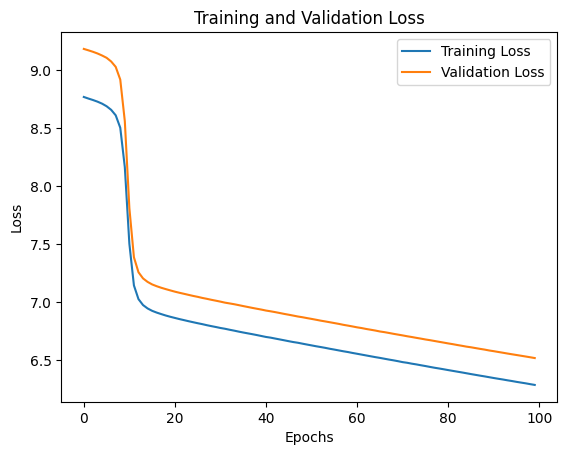

In [74]:
trainset = torch.utils.data.TensorDataset(
    torch.Tensor(X_train), torch.Tensor(y_train)
)
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=256, shuffle=True, num_workers=1
)
valset = torch.utils.data.TensorDataset(
    torch.Tensor(X_val), torch.Tensor(y_val)
)
val_loader = torch.utils.data.DataLoader(
    valset, batch_size=256, shuffle=True, num_workers=1
)


mlp = train_MLP_mnist(train_loader, val_loader)

In [81]:
with torch.set_grad_enabled(False):
    y_pred = mlp(torch.Tensor(X_val)).numpy()
    rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))

In [82]:
rmse

2.5529500666193754

In [90]:
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [108]:
forest = RandomForestRegressor(random_state=1, max_features=1 / 6).fit(X_train, y_train)
boosted = GradientBoostingRegressor(random_state=0).fit(X_train, y_train)

In [109]:
y_pred = forest.predict(X_val)
print(np.sqrt(np.mean((y_pred - y_val) ** 2)))
y_pred = boosted.predict(X_val)
print(np.sqrt(np.mean((y_pred - y_val) ** 2)))

0.5027404542297231
0.5169230113584179
